In [101]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import *
from sklearn.ensemble import *
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.metrics import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

sns.set(font="simhei", style="white", font_scale=1.6)
import matplotlib

matplotlib.rcParams['axes.unicode_minus'] = False  # 解决坐标轴的负号显示问题


def chinese2english(df):
    columnsDict = {
        'Length': '长度',
        'Geographic Region': '地理区域',
        'Country': '国家',
        'Listing Price': '售价',
        'Year': '年份',
        'Make Variant': '名称',
        'LWL': '水线长度',
        'Beam': '宽度',
        'Draft': '吃水',
        'Displacement': '排水',
        'Sail Area': '帆面积',
        'AVG Cargo Thro.': '平均货物吞吐量',
        'GDP': 'GDP',
        'GDP per capita': '人均GDP',
        'Average proportion of total logistics cost to GDP': '物流总成本占GDP的平均比例',
        'Hull Type': '类型',
    }
    print({v: k for k, v in columnsDict.items()})
    return df.rename(columns={v: k for k, v in columnsDict.items()})


def getxy(dataPath, sheetName, customFun=None):
    # r'香港数据 (1).xlsx'
    def fun():
        exceptCol = [
            '地理区域',
            '平均货物吞吐量',
            '人均GDP',
            '物流总成本占GDP的平均比例',
        ]

        df = pd.read_excel(dataPath, sheet_name=sheetName)
        df.drop(columns=exceptCol, inplace=True, axis=1)
        if customFun is not None:
            customFun(df)
        X = df
        y = df.pop('售价')
        return X, y, df

    return fun

----------ridge----------
------------


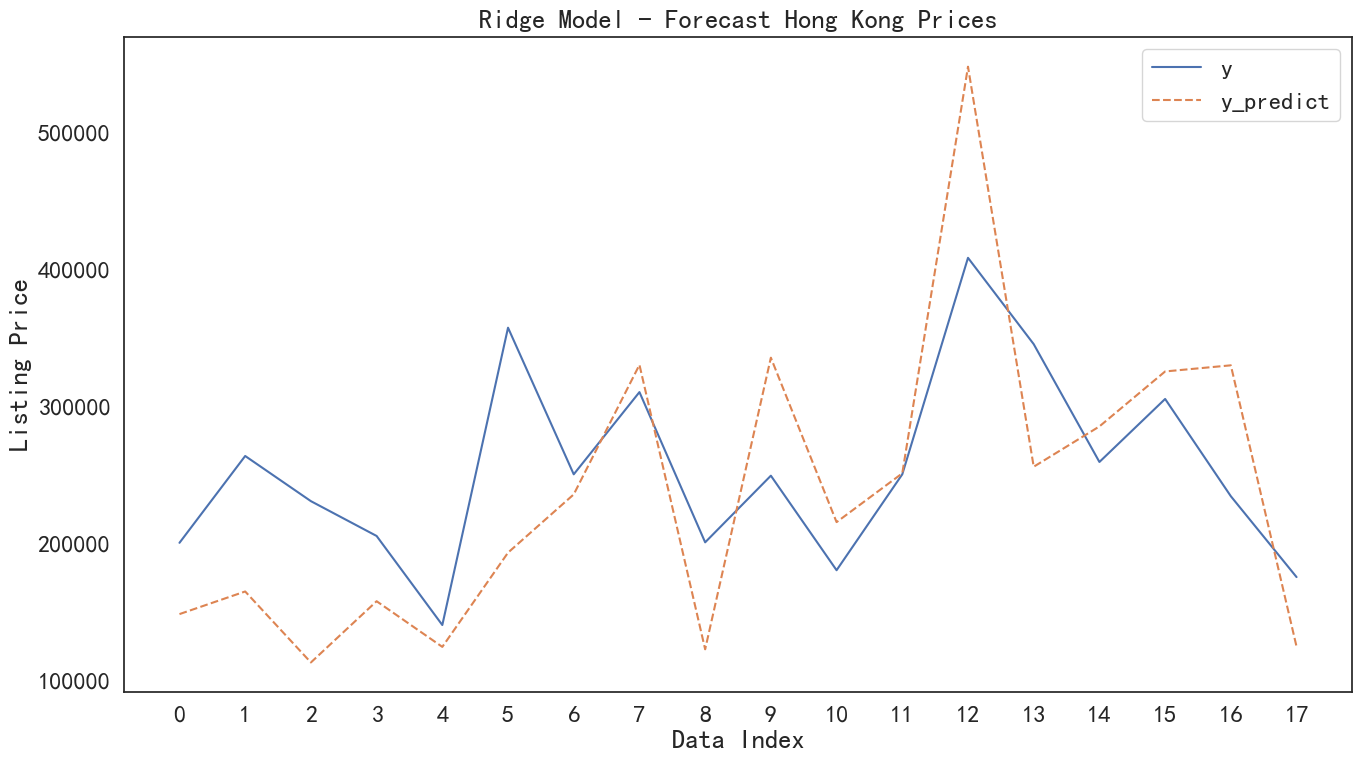

平均价格变化: -17025.253452131845
平均价格变化率: -7.202743009372369
MSE: -17025.253452131827
----------catBoost----------
------------


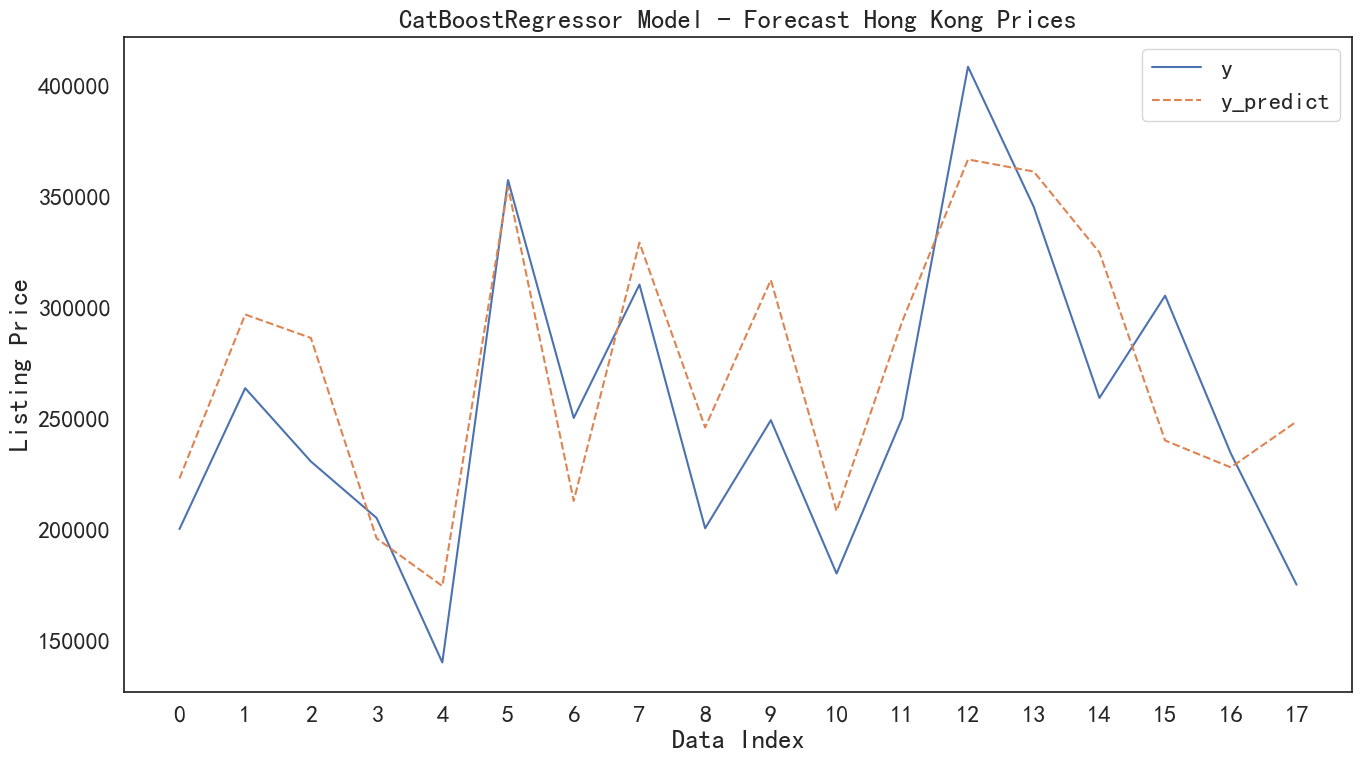

平均价格变化: 18712.950104583753
平均价格变化率: 6.87697979322227
MSE: 18712.95010458376


In [102]:

def test(model, getxy, x_sampled=None, additionFilename='', pltTitle='', log=''):
    print(f'------{log}------')
    plt.figure(figsize=(14, 8))
    modelName = type(model).__name__
    X, y, _ = getxy()

    # 使用模型进行预测
    y_pred = model.predict(X)

    # 减少数据点的数量
    if x_sampled is None:
        x_sampled = np.arange(len(X['年份'])).astype('int64')
        plt.xticks(x_sampled)
    else:
        x_sampled = x_sampled(X, y)
    y_pred = y_pred[x_sampled]
    y = y[x_sampled]

    # 还原价格
    y_pred = np.exp(y_pred)
    y = np.exp(y)

    title = f'{modelName} Model - {pltTitle}'
    plt.plot(x_sampled, y, label='y')
    plt.plot(x_sampled, y_pred, label='y_predict', linestyle='--')
    plt.xlabel('Data Index')
    plt.ylabel('Listing Price')
    plt.title(title)
    plt.tight_layout()
    plt.legend()
    plt.savefig(f'{additionFilename}-{title}.svg')
    plt.show()

    y_delta = y_pred.mean() - y.mean()
    print(f'平均价格变化: {y_delta}')
    print(f'平均价格变化率: {y_delta / y_pred.mean() * 100}')
    print(f'MSE: {(y_pred - y).sum() / len(y)}')


'''
预测香港本身数据
'''
# 加载模型数据
with open('../T1/regressive/Ridge.pkl', 'rb') as f:
    print(f'----------ridge----------')
    ridge = pickle.load(f)
    test(ridge, getxy(r'香港数据 (1).xlsx', 'Sheet2', lambda df: df.pop('原价')), pltTitle='Forecast Hong Kong Prices')

# 加载模型数据
with open('../T1/regressive/CatBoostRegressor.pkl', 'rb') as f:
    print(f'----------catBoost----------')
    catBoost = pickle.load(f)
    test(catBoost, getxy(r'香港数据 (1).xlsx', 'Sheet2', lambda df: df.pop('原价')),
         pltTitle='Forecast Hong Kong Prices')


In [103]:
df

,长度,国家,年份,名称,水线长度,宽度,吃水,排水,帆面积,GDP,类型
0,41,5,7,83,43,14.04,6.67,10.000886,82.4,2431.437,0
1,38,5,13,83,49,16.27,7.74,9.644199,72.1,3502.541,0
2,38,5,9,329,62,16.70,11.81,9.644199,72.1,2558.587,0
3,38,5,9,83,37,13.09,8.90,9.644199,72.1,2558.587,0
4,38,5,8,4,39,13.08,3.42,9.644199,72.1,2483.115,0
5,38,5,14,329,54,15.50,13.42,9.644199,72.1,3498.570,0
6,39,5,4,279,38,12.58,7.90,9.884356,77.6,1940.615,1
7,41,5,12,17,42,12.96,8.30,9.814547,90.2,3212.665,1
8,41,5,4,398,55,14.99,10.50,9.814547,90.2,1940.615,0
9,42,5,13,83,23,8.50,4.67,9.867342,91.5,3502.541,0


----------ridge----------
------单体-模拟香港对价格的影响------


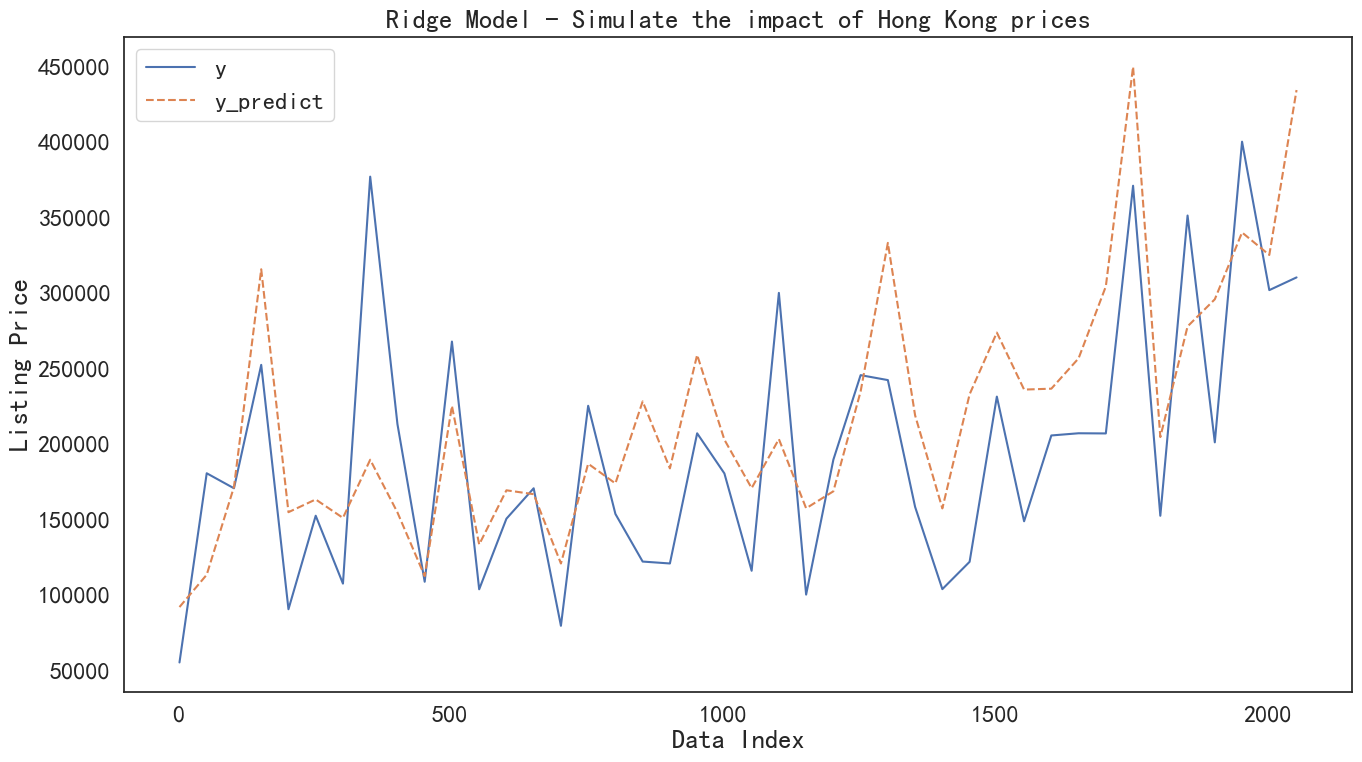

平均价格变化: 24405.924023791886
平均价格变化率: 11.194936835514362
MSE: 24405.924023791922
------双体-模拟香港对价格的影响------


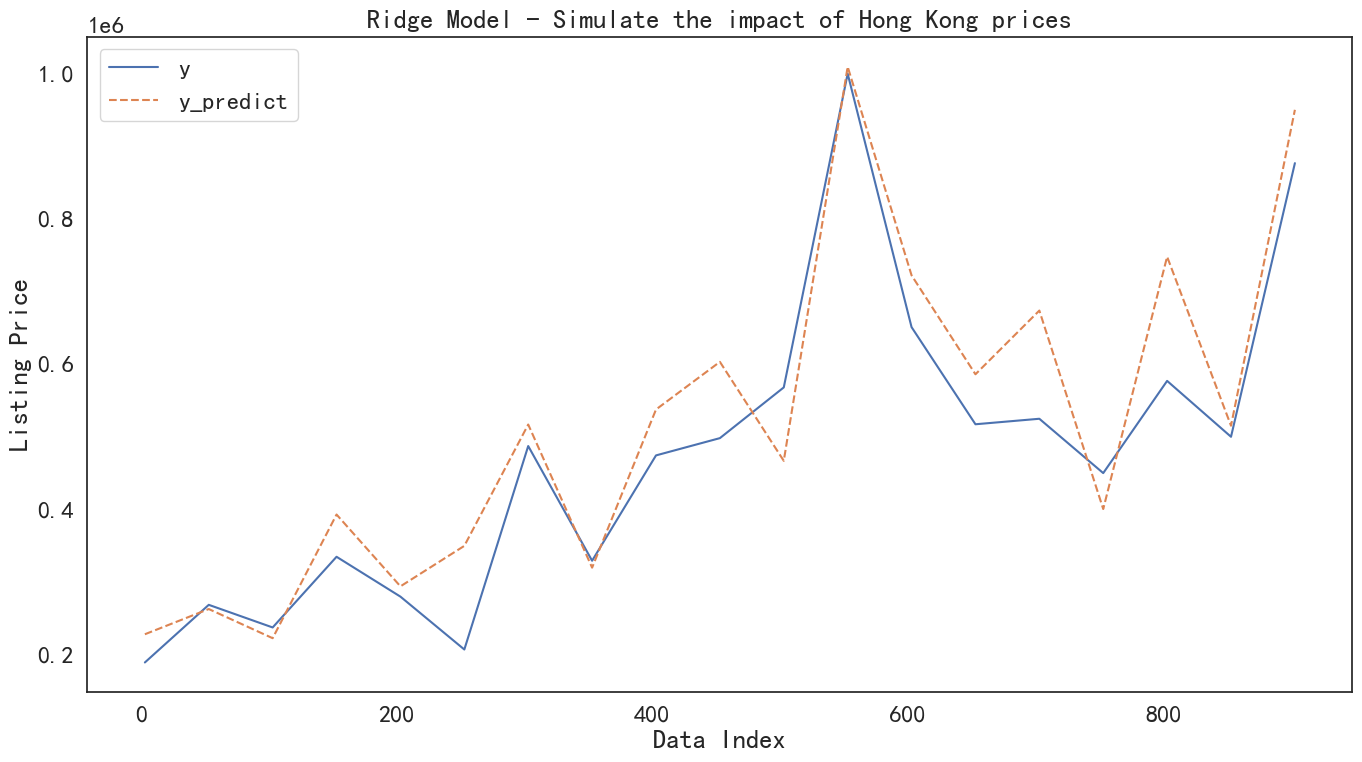

平均价格变化: 43651.178928712674
平均价格变化率: 8.479114406623562
MSE: 43651.178928712674
----------catBoost----------
------单体-模拟香港对价格的影响------


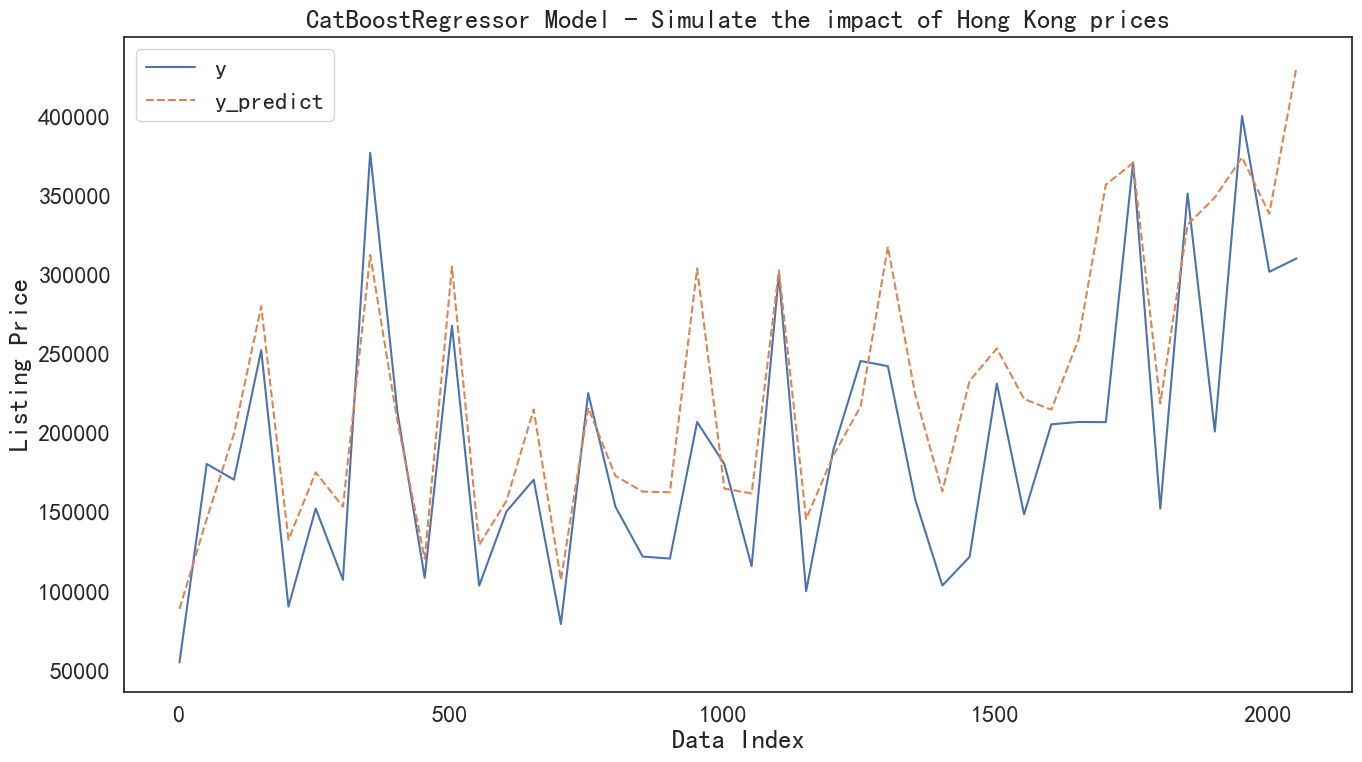

平均价格变化: 34086.625523530936
平均价格变化率: 14.970675693900027
MSE: 34086.625523530936
------双体-模拟香港对价格的影响------


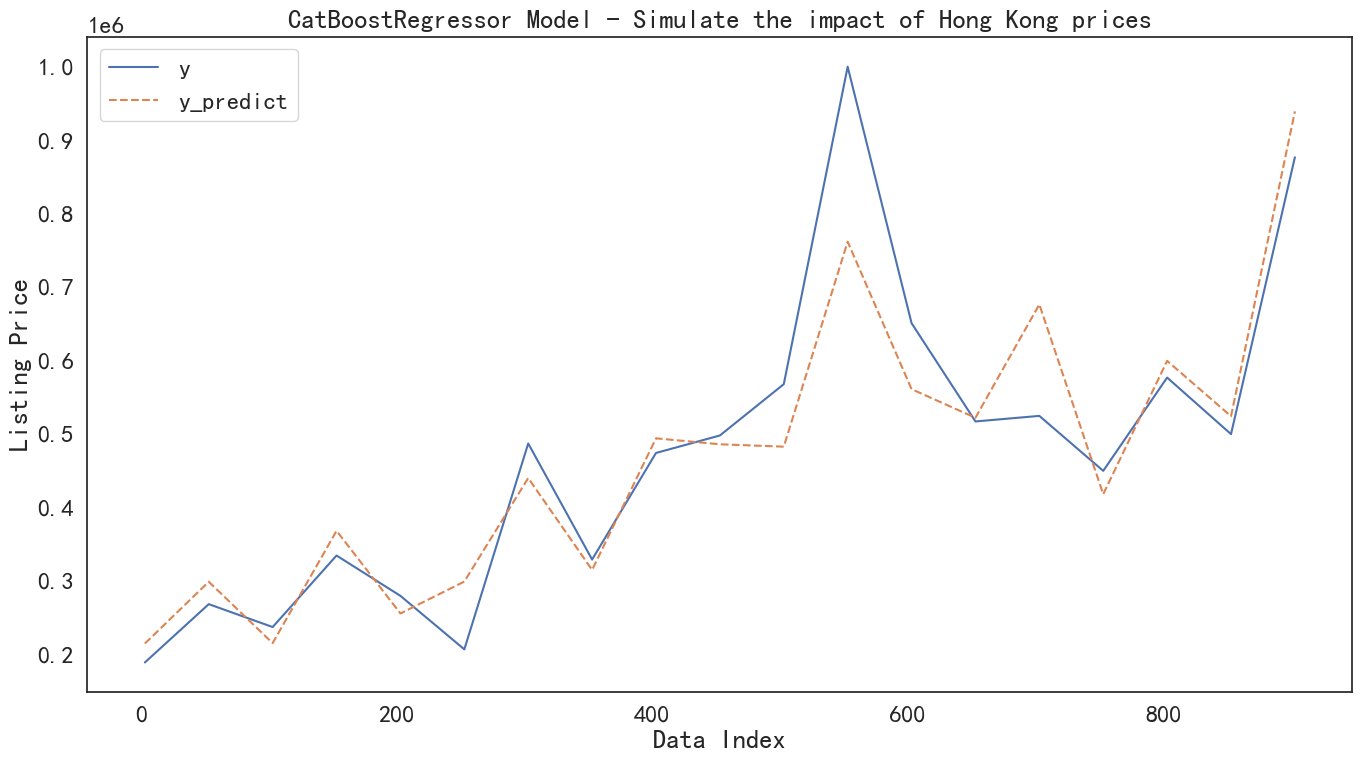

平均价格变化: -5021.086561372387
平均价格变化率: -1.07717209716792
MSE: -5021.086561372522


In [104]:
'''
把其他帆船应用到香港地区，看误差
'''


def xScale(X, y):
    return np.arange(3, len(X['年份']), 50).astype('int64')


pltTitle = 'Simulate the impact of Hong Kong prices'
# 加载模型数据
with open('../T1/regressive/Ridge.pkl', 'rb') as f:
    print(f'----------ridge----------')
    ridge = pickle.load(f)
    test(ridge, getxy(r'./模拟香港数据/单体-合并修正缩放后总数据.xlsx', '已编码汇总'), xScale, pltTitle=pltTitle,
         additionFilename='单体-模拟香港对价格的影响', log='单体-模拟香港对价格的影响')
    test(ridge, getxy(r'./模拟香港数据/双体-合并修正缩放后总数据.xlsx', '已编码汇总'), xScale, pltTitle=pltTitle,
         additionFilename='双体-模拟香港对价格的影响', log='双体-模拟香港对价格的影响')

# 加载模型数据
with open('../T1/regressive/CatBoostRegressor.pkl', 'rb') as f:
    print(f'----------catBoost----------')
    catBoost = pickle.load(f)
    test(catBoost, getxy(r'./模拟香港数据/单体-合并修正缩放后总数据.xlsx', '已编码汇总'), xScale, pltTitle=pltTitle,
         additionFilename='单体-模拟香港对价格的影响', log='单体-模拟香港对价格的影响')
    test(catBoost, getxy(r'./模拟香港数据/双体-合并修正缩放后总数据.xlsx', '已编码汇总'), xScale, pltTitle=pltTitle,
         additionFilename='双体-模拟香港对价格的影响', log='双体-模拟香港对价格的影响')